In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exploración de Datos

In [41]:
df = pd.read_excel('consumo.xlsx', engine='openpyxl')
df = df[['Fecha', 'Gasolina superior', 'Gasolina regular', 'Diesel']]

In [42]:
df = df[:269]
df['Fecha'] = pd.to_datetime(df['Fecha'])

In [43]:
df

,Fecha,Gasolina superior,Gasolina regular,Diesel
0,2000-01-01,308157,202645,634667
1,2000-02-01,307766,205531,642381
2,2000-03-01,331910,229500,699807
3,2000-04-01,315648,210680,586804
4,2000-05-01,319668,208164,656948
...,...,...,...,...
264,2022-01-01,622475,684004,1.29426e+06
265,2022-02-01,592075,660944,1.27576e+06
266,2022-03-01,599582,703128,1.3452e+06
267,2022-04-01,566128,807440,1.29416e+06


In [54]:
quant_vars = ['Gasolina superior', 'Gasolina regular', 'Diesel']
df[quant_vars].describe()

,Gasolina superior,Gasolina regular,Diesel
count,269.00,269.00,269.0
unique,269.00,269.00,269.0
top,394751.47,643070.35,785917.4
freq,1.00,1.00,1.0


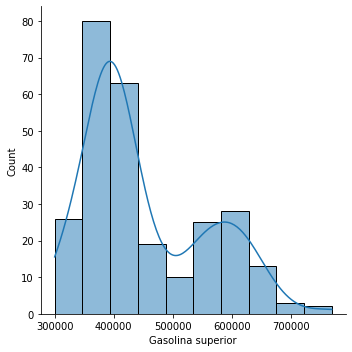

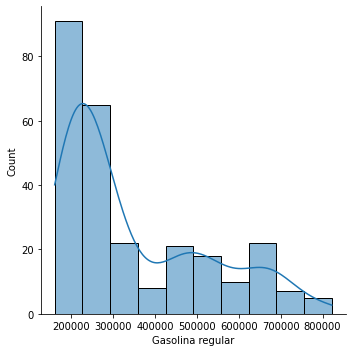

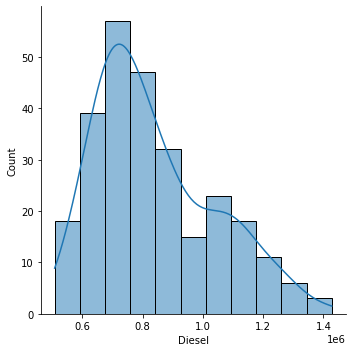

In [46]:
for var in quant:
    data = df[var].dropna(how='all', axis=0)
    
    # Gráfico
    sns.displot(data, kde=True)

# Por año

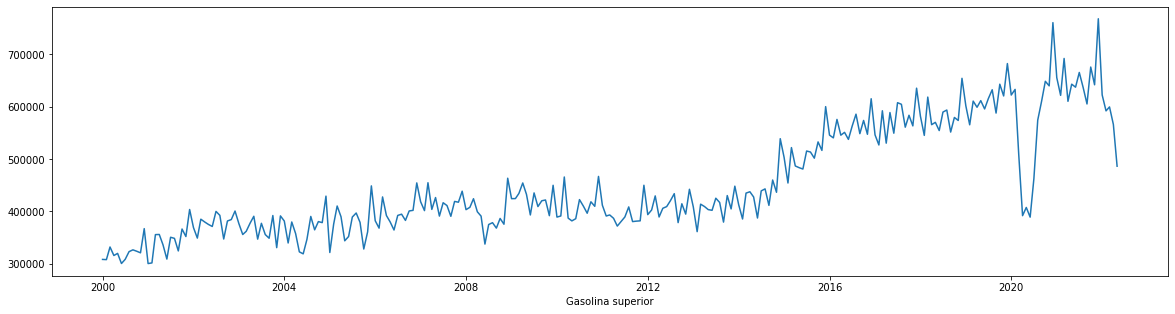

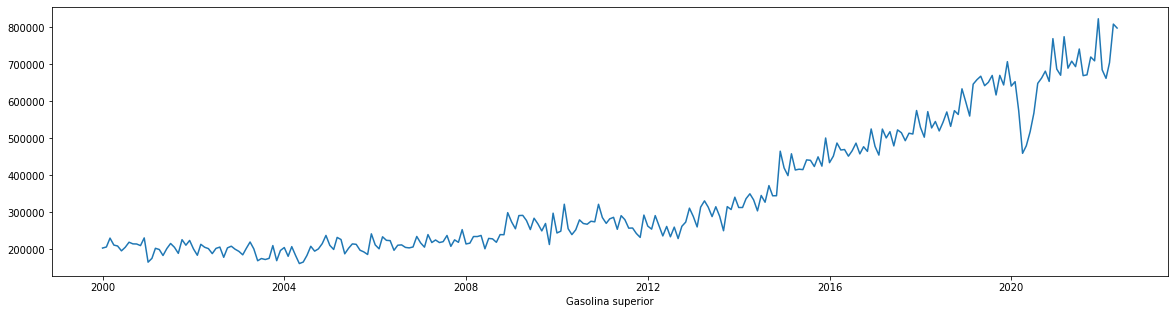

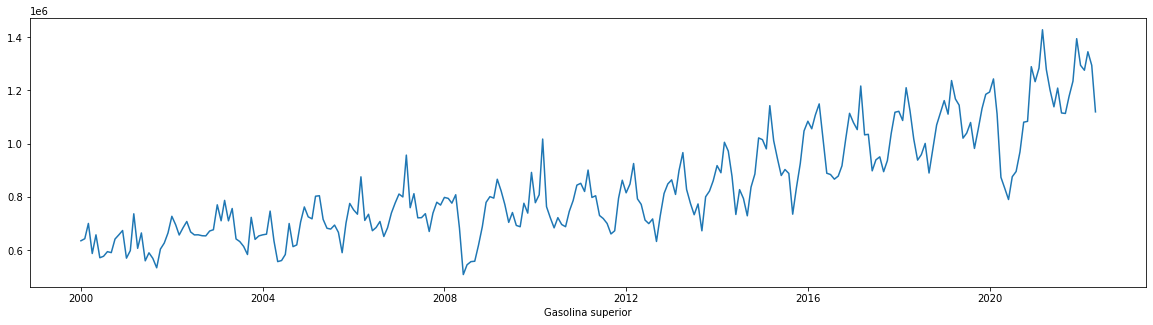

In [82]:
plt.rcParams["figure.figsize"] = (20,5.5)

for gas in quant_vars:
    x = df['Fecha']
    y = df[gas]

    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.xlabel('Gasolina superior')


    plt.plot(x, y)
    plt.show()

# Por mes

In [71]:
dfPerMonth = df.groupby(df['Fecha'].dt.month)
dfPerMonth = dfPerMonth.sum()

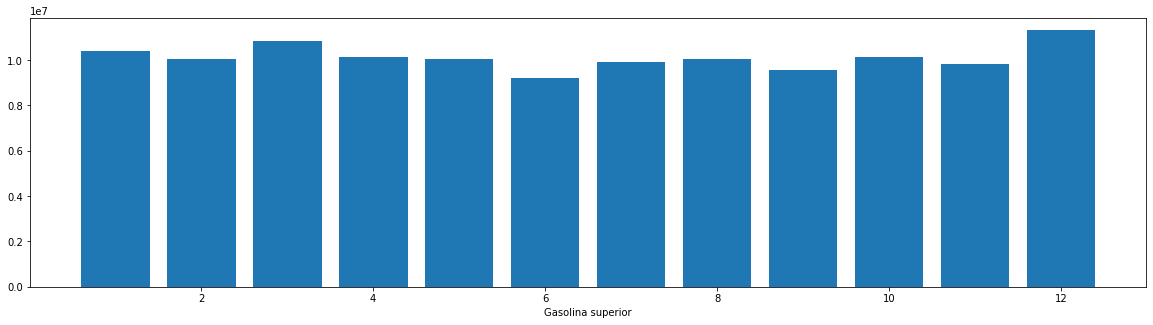

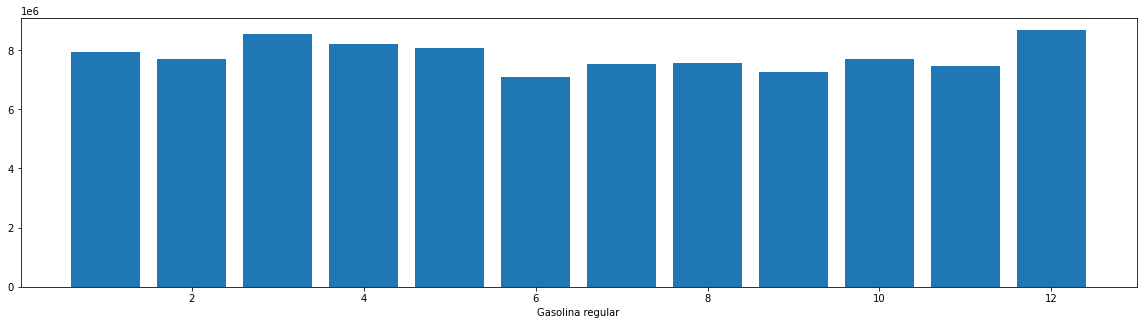

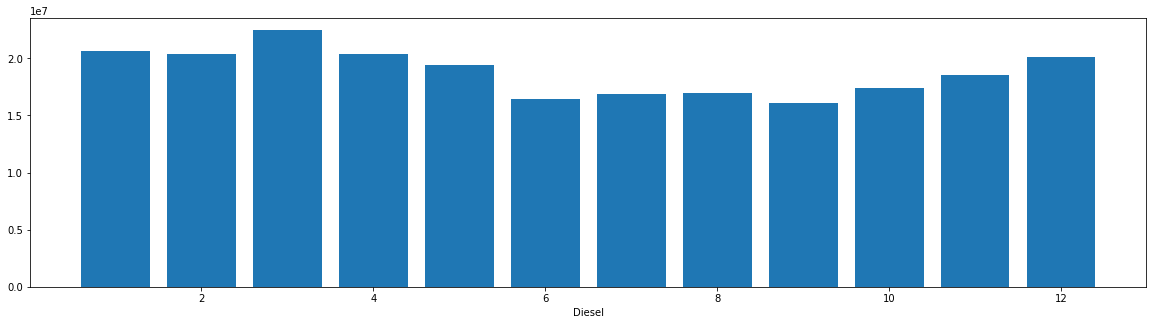

In [83]:
plt.rcParams["figure.figsize"] = (20,5.5)

for gas in quant_vars:
    x = dfPerMonth.index
    y = dfPerMonth[gas]

    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.xlabel(gas)


    plt.bar(x, y)
    plt.show()